In [1]:
import pandas as pd 
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date

In [2]:
DF=pd.read_csv('fire.csv')

In [3]:
DF.head()

,Date,Station Area,Description,TOC,ORD,MOB,IA,LS,AH,MAV,CD
0,01/01/2013,Rathfarnham,S/S OTHER,01:27:19,01:28:58,01:30:47,01:58:54,NaN,NaN,01:59:02,02:05:05
1,01/01/2013,Tallaght,Fire CAR,01:49:57,01:50:40,01:51:47,01:55:43,NaN,NaN,02:03:22,02:12:03
2,01/01/2013,North Strand,S/S RTA,03:35:24,03:36:14,03:38:28,03:41:20,NaN,NaN,03:59:44,04:21:07
3,01/01/2013,Tallaght,Fire CAR,04:12:51,04:13:56,04:14:32,04:20:48,NaN,NaN,04:34:39,04:37:02
4,01/01/2013,Finglas,Fire DOM PER,04:14:24,04:15:36,04:17:37,04:20:47,NaN,NaN,04:27:30,04:33:51


## Cleaning Data

Firstly I want to remove my AH and MAV columns as these are only relevent to ambulance data.
The main columns we want to work with from this data set are Date, Station Area, Description, TOC and IA.
The rest we will drop.

In [4]:
DF=DF.drop(columns=['LS','AH','ORD','MOB','MAV','CD'])
DF.head()

,Date,Station Area,Description,TOC,IA
0,01/01/2013,Rathfarnham,S/S OTHER,01:27:19,01:58:54
1,01/01/2013,Tallaght,Fire CAR,01:49:57,01:55:43
2,01/01/2013,North Strand,S/S RTA,03:35:24,03:41:20
3,01/01/2013,Tallaght,Fire CAR,04:12:51,04:20:48
4,01/01/2013,Finglas,Fire DOM PER,04:14:24,04:20:47


In [5]:
DF.shape

(38555, 5)

In [6]:
DF.isnull().sum(axis = 0)

Date               0
Station Area       0
Description        0
TOC                0
IA              7593
dtype: int64

I need to add a column in that will indicate the actual response time. This will be done using the TOC (time of call) column and the IA (In Attendance) column. As can be seen above, TOC has no null values. However, IA has 7593 null values. This is discussed in my report, as to why these values are null. My course of action at this point is to fully delete the rows in whihc the corresponding IA value is null.

In [7]:
DF = DF.dropna(axis=0, subset=['IA'])

Examining the shape of the dataframe now, and the null values 

In [8]:
DF.shape

(30962, 5)

In [9]:
DF.isnull().sum(axis = 0)

Date            0
Station Area    0
Description     0
TOC             0
IA              0
dtype: int64

We can now see that all the rows in which the corresponding 'IA' (In Attendance) value is null, have been deleted from the data frame. 

Next I want to calculate the response time. To do this I want to ensure that my two key columns that I will be working with i.e. 'TOC' and 'IA' are in date time format. This is key in order to accurately subtract one from the other.

In [10]:
DF.dtypes

Date            object
Station Area    object
Description     object
TOC             object
IA              object
dtype: object

Currently, they are objects. So I will change this:

In [11]:
DF.loc[:,'TOC'] = pd.to_datetime(DF.Date.astype(object)+' '+DF.TOC.astype(object))
DF.loc[:,'IA'] = pd.to_datetime(DF.Date.astype(object)+' '+DF.IA.astype(object))

In [12]:
DF.head()

,Date,Station Area,Description,TOC,IA
0,01/01/2013,Rathfarnham,S/S OTHER,2013-01-01 01:27:19,2013-01-01 01:58:54
1,01/01/2013,Tallaght,Fire CAR,2013-01-01 01:49:57,2013-01-01 01:55:43
2,01/01/2013,North Strand,S/S RTA,2013-01-01 03:35:24,2013-01-01 03:41:20
3,01/01/2013,Tallaght,Fire CAR,2013-01-01 04:12:51,2013-01-01 04:20:48
4,01/01/2013,Finglas,Fire DOM PER,2013-01-01 04:14:24,2013-01-01 04:20:47


As we can see above,they are now formatted differently and in the correct way in order to work with them as a datetime variable.

## Calculating Response Time

As stated in my report, in the contect of emergency services response times, seconds can make all the difference. As such, I have decided to convert the response time into seconds.

In [13]:
DF['Response Time'] = DF['IA'] - DF['TOC']
DF['Response Time']=DF['Response Time']/np.timedelta64(1,'s')
 
DF.head()

,Date,Station Area,Description,TOC,IA,Response Time
0,01/01/2013,Rathfarnham,S/S OTHER,2013-01-01 01:27:19,2013-01-01 01:58:54,1895.0
1,01/01/2013,Tallaght,Fire CAR,2013-01-01 01:49:57,2013-01-01 01:55:43,346.0
2,01/01/2013,North Strand,S/S RTA,2013-01-01 03:35:24,2013-01-01 03:41:20,356.0
3,01/01/2013,Tallaght,Fire CAR,2013-01-01 04:12:51,2013-01-01 04:20:48,477.0
4,01/01/2013,Finglas,Fire DOM PER,2013-01-01 04:14:24,2013-01-01 04:20:47,383.0


In [14]:
mask = (DF['Response Time'] <0 )
DF['TOC'][mask] = DF['TOC'] -pd.Timedelta('1 day')
DF['Response Time'].mask(DF['Response Time'] < 0, 86400 +DF['Response Time'], inplace=True)

C:\Users\Lauren\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


What I have done here is in regards to when the time between the TOC and IA run between two days. Currently, the date time is incorrectly assigning calls that were made just before midnight to the next day. I have chaged this date.

I also had to change the way the response time was being calculated for these values.

Upon examining my data, it looks like there still have been a few human errors in terms of data collection, as some response times seem to have taken nearly hours which cannot be possible. For example, on the 27th of January 2015 a fire bridgade is called at 1:41am, and the fire bridgade does not arrive until 1:00am on the 28th of January. For examples like these, I am going to filter them out. I believe that if it is taking a fire brigade more than 6 hours to get there we can safely say it is a mistake.

In [15]:
my_counter = len(DF[DF['Response Time'] > 21600])
my_counter

9

In [16]:
Unusual_data=DF[DF['Response Time'] > 21600]
Unusual_data

,Date,Station Area,Description,TOC,IA,Response Time
6473,15/07/2013,Dun Laoghaire,Fire GORSE,2013-07-14 17:15:18,2013-07-15 11:41:12,66354.0
23764,26/10/2014,Donnybrook,S/S AMBASS,2014-10-25 01:57:42,2014-10-26 01:06:01,83299.0
27033,28/01/2015,Dolphins Barn,S/S FLDING,2015-01-27 01:41:28,2015-01-28 01:00:46,83958.0
27044,29/01/2015,Kilbarrack,Fire DOMESTIC,2015-01-28 01:50:15,2015-01-29 01:00:58,83443.0
29045,07/04/2015,Dun Laoghaire,Fire GORSE,2015-07-03 21:50:57,2015-07-04 09:34:50,42233.0
29232,13/04/2015,Kilbarrack,Fire GORSE,2015-04-13 00:31:53,2015-04-13 09:56:36,33883.0
29581,24/04/2015,Dun Laoghaire,Fire GORSE,2015-04-24 01:45:09,2015-04-24 11:07:38,33749.0
30237,19/05/2015,Dun Laoghaire,Fire SMALL,2015-05-18 19:00:44,2015-05-19 13:05:30,65086.0
30250,20/05/2015,Tallaght,Fire ALARM,2015-05-19 23:45:37,2015-05-20 12:44:47,46750.0


In [17]:
DF.drop(DF[DF['Response Time'] > 43200].index, inplace=True)

## Adding in Weather Data

In [18]:
weather=pd.read_csv('weather_historical_data.csv')

In [19]:
weather.head()

,Location,Address,Resolved Address,Date time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow Depth,Wind Speed,Wind Gust,Cloud Cover,Relative Humidity,Conditions
0,NaN,"Dublin, L, IE","Dublin, L, IE",01/01/2013,45.0,36.5,40.5,29.2,NaN,NaN,NaN,13.0,NaN,28.7,84.47,Partially cloudy
1,NaN,"Dublin, L, IE","Dublin, L, IE",01/02/2013,52.9,43.9,49.9,39.3,NaN,0.1,NaN,15.1,NaN,63.0,93.22,"Rain, Partially cloudy"
2,NaN,"Dublin, L, IE","Dublin, L, IE",01/03/2013,54.1,50.5,51.7,NaN,NaN,NaN,NaN,12.3,NaN,55.2,90.82,Partially cloudy
3,NaN,"Dublin, L, IE","Dublin, L, IE",01/04/2013,51.1,45.8,49.4,43.8,NaN,NaN,NaN,16.4,NaN,65.2,86.87,Partially cloudy
4,NaN,"Dublin, L, IE","Dublin, L, IE",01/05/2013,52.4,46.6,50.1,43.0,NaN,NaN,NaN,16.1,NaN,47.8,88.55,Partially cloudy


In [20]:
new_weather=weather[['Date time','Precipitation','Wind Speed']]

In [21]:
new_weather.head()

,Date time,Precipitation,Wind Speed
0,01/01/2013,NaN,13.0
1,01/02/2013,0.1,15.1
2,01/03/2013,NaN,12.3
3,01/04/2013,NaN,16.4
4,01/05/2013,NaN,16.1


In [22]:
new_weather=new_weather.fillna(0)
new_weather.rename(columns={'Date time':'Date'}, inplace=True) # changing name of column in order to merge
new_weather.head(5)

,Date,Precipitation,Wind Speed
0,01/01/2013,0.0,13.0
1,01/02/2013,0.1,15.1
2,01/03/2013,0.0,12.3
3,01/04/2013,0.0,16.4
4,01/05/2013,0.0,16.1


In [23]:
DF['Date'] = pd.to_datetime(DF['Date'], format='%d/%m/%Y')
new_weather['Date'] = pd.to_datetime(new_weather['Date'], format='%m/%d/%Y')

In [24]:
DF = pd.merge(DF, new_weather, on='Date')
DF.head(20)

,Date,Station Area,Description,TOC,IA,Response Time,Precipitation,Wind Speed
0,2013-01-01,Rathfarnham,S/S OTHER,2013-01-01 01:27:19,2013-01-01 01:58:54,1895.0,0.0,13.0
1,2013-01-01,Tallaght,Fire CAR,2013-01-01 01:49:57,2013-01-01 01:55:43,346.0,0.0,13.0
2,2013-01-01,North Strand,S/S RTA,2013-01-01 03:35:24,2013-01-01 03:41:20,356.0,0.0,13.0
3,2013-01-01,Tallaght,Fire CAR,2013-01-01 04:12:51,2013-01-01 04:20:48,477.0,0.0,13.0
4,2013-01-01,Finglas,Fire DOM PER,2013-01-01 04:14:24,2013-01-01 04:20:47,383.0,0.0,13.0
5,2013-01-01,Tallaght,S/S OTHER,2013-01-01 04:54:30,2013-01-01 05:09:48,918.0,0.0,13.0
6,2013-01-01,Dun Laoghaire,Fire ALARM,2013-01-01 05:12:03,2013-01-01 05:25:13,790.0,0.0,13.0
7,2013-01-01,Balbriggan,Fire ALARM,2013-01-01 05:59:23,2013-01-01 06:10:10,647.0,0.0,13.0
8,2013-01-01,Kilbarrack,Fire ALARM,2013-01-01 06:07:42,2013-01-01 06:13:47,365.0,0.0,13.0
9,2013-01-01,Dolphins Barn,S/S GRDASS,2013-01-01 06:25:31,2013-01-01 06:32:39,428.0,0.0,13.0


## Adding in Events

In [25]:
events=pd.read_csv('events.csv')
events=events.fillna('none')
events.rename(columns={'Type':'Event'}, inplace=True)
events.head()

,Date,Event
0,01/01/2013,Christmas Break
1,01/02/2013,Christmas Break
2,01/03/2013,Christmas Break
3,01/04/2013,Christmas Break
4,01/05/2013,none


In [26]:
events['Date'] = pd.to_datetime(events['Date'], format='%m/%d/%Y')
DF = pd.merge(DF, events, on='Date')
DF.Event.unique()

array(['Christmas Break', 'none', 'Rugby Match', 'Mid Term',
       "St Patrick's Day", 'Easter', 'Football Match', 'Hurling Match',
       'Marathon', 'Christmas Eve', 'Christmas', "St Stephen's Day",
       'New Years Eve', 'New Years Day'], dtype=object)

## Picking out more conditions for regression

In [27]:
DF['Hour'] = DF['TOC'].dt.hour
DF['Day']=DF['TOC'].dt.day
DF['Month']=DF['TOC'].dt.month
DF.head()

,Date,Station Area,Description,TOC,IA,Response Time,Precipitation,Wind Speed,Event,Hour,Day,Month
0,2013-01-01,Rathfarnham,S/S OTHER,2013-01-01 01:27:19,2013-01-01 01:58:54,1895.0,0.0,13.0,Christmas Break,1,1,1
1,2013-01-01,Tallaght,Fire CAR,2013-01-01 01:49:57,2013-01-01 01:55:43,346.0,0.0,13.0,Christmas Break,1,1,1
2,2013-01-01,North Strand,S/S RTA,2013-01-01 03:35:24,2013-01-01 03:41:20,356.0,0.0,13.0,Christmas Break,3,1,1
3,2013-01-01,Tallaght,Fire CAR,2013-01-01 04:12:51,2013-01-01 04:20:48,477.0,0.0,13.0,Christmas Break,4,1,1
4,2013-01-01,Finglas,Fire DOM PER,2013-01-01 04:14:24,2013-01-01 04:20:47,383.0,0.0,13.0,Christmas Break,4,1,1


Creating an 'IsWeekend' column to include as a feature

In [28]:
group=DF.groupby('Hour')
df2=group.apply(lambda x: x['Response Time'].mean())
df2.head()

Hour
0    610.535881
1    610.943978
2    606.025316
3    578.616568
4    591.690066
dtype: float64

In [29]:
hour_plot=df2.plot(kind='bar')
hour_plot.set_ylabel("Average Response Time")


Text(0, 0.5, 'Average Response Time')

In [30]:
DF['IsWeekend'] = ((pd.DatetimeIndex(DF.Date).dayofweek) // 5 == 1).astype(float)
DF.head()

,Date,Station Area,Description,TOC,IA,Response Time,Precipitation,Wind Speed,Event,Hour,Day,Month,IsWeekend
0,2013-01-01,Rathfarnham,S/S OTHER,2013-01-01 01:27:19,2013-01-01 01:58:54,1895.0,0.0,13.0,Christmas Break,1,1,1,0.0
1,2013-01-01,Tallaght,Fire CAR,2013-01-01 01:49:57,2013-01-01 01:55:43,346.0,0.0,13.0,Christmas Break,1,1,1,0.0
2,2013-01-01,North Strand,S/S RTA,2013-01-01 03:35:24,2013-01-01 03:41:20,356.0,0.0,13.0,Christmas Break,3,1,1,0.0
3,2013-01-01,Tallaght,Fire CAR,2013-01-01 04:12:51,2013-01-01 04:20:48,477.0,0.0,13.0,Christmas Break,4,1,1,0.0
4,2013-01-01,Finglas,Fire DOM PER,2013-01-01 04:14:24,2013-01-01 04:20:47,383.0,0.0,13.0,Christmas Break,4,1,1,0.0


In [31]:
group2=DF.groupby('IsWeekend')
df3=group2.apply(lambda x: x['Response Time'].mean())
df3.head()

IsWeekend
0.0    625.858945
1.0    601.204902
dtype: float64

Text(0, 0.5, 'Average Response Time')

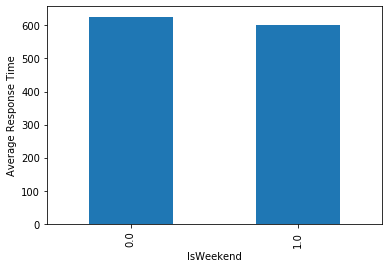

In [32]:
weekend_plot=df3.plot(kind='bar')
weekend_plot.set_ylabel("Average Response Time")


In [33]:
DF.Month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

Changing variables to categorical

In [34]:
DF['Hour'] = pd.Categorical(DF.Hour)
DF['Day'] = pd.Categorical(DF.Day)
DF['Month'] = pd.Categorical(DF.Month)
DF['Station Area'] = pd.Categorical(DF['Station Area'])
DF['Description'] = pd.Categorical(DF.Description)

In [35]:
DF.dtypes

Date             datetime64[ns]
Station Area           category
Description            category
TOC              datetime64[ns]
IA               datetime64[ns]
Response Time           float64
Precipitation           float64
Wind Speed              float64
Event                    object
Hour                   category
Day                    category
Month                  category
IsWeekend               float64
dtype: object

Using get dummies function in order to make each of the values in the categorical variables into their own outright feature

In [36]:
DF = pd.get_dummies(DF, prefix_sep='_', drop_first=True)
DF.head()

,Date,TOC,IA,Response Time,Precipitation,Wind Speed,IsWeekend,Station Area_Blanchardstown,Station Area_Dolphins Barn,Station Area_Donnybrook,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,2013-01-01,2013-01-01 01:27:19,2013-01-01 01:58:54,1895.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-01,2013-01-01 01:49:57,2013-01-01 01:55:43,346.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-01,2013-01-01 03:35:24,2013-01-01 03:41:20,356.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-01,2013-01-01 04:12:51,2013-01-01 04:20:48,477.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-01,2013-01-01 04:14:24,2013-01-01 04:20:47,383.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Looking at each of the features now included in the dataframe

In [37]:
for col in DF.columns: 
    print(col) 

Date
TOC
IA
Response Time
Precipitation
Wind Speed
IsWeekend
Station Area_Blanchardstown
Station Area_Dolphins Barn
Station Area_Donnybrook
Station Area_Dun Laoghaire
Station Area_Dunshaughlin
Station Area_Finglas
Station Area_Kilbarrack
Station Area_MH14
Station Area_North Strand
Station Area_Phibsborough
Station Area_Rathfarnham
Station Area_Skerries
Station Area_Swords
Station Area_Tallaght
Station Area_Tara St
Description_Fire AIRCRC
Description_Fire AIRCRD
Description_Fire ALARM
Description_Fire BUS
Description_Fire CAR
Description_Fire CARAVAN
Description_Fire CHIMNEY
Description_Fire CONTBURN
Description_Fire DOM PER
Description_Fire DOMESTIC
Description_Fire FIRE
Description_Fire FOREST
Description_Fire GORSE
Description_Fire GRASS
Description_Fire HAY/BARN
Description_Fire HIGHRISE
Description_Fire INDUST
Description_Fire INSTIT
Description_Fire LUAS
Description_Fire MBIKE
Description_Fire OIL/PET
Description_Fire SMALL
Description_Fire SMOKE
Description_Fire TRAIN
Description

Splitting into test and training sets

In [38]:
test = DF[DF['TOC'].dt.year == 2015]
train=DF[DF['TOC'].dt.year != 2015]
test.head()

,Date,TOC,IA,Response Time,Precipitation,Wind Speed,IsWeekend,Station Area_Blanchardstown,Station Area_Dolphins Barn,Station Area_Donnybrook,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
21158,2015-01-01,2015-01-01 00:00:05,2015-01-01 00:06:00,355.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21159,2015-01-01,2015-01-01 00:00:17,2015-01-01 00:13:22,785.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21160,2015-01-01,2015-01-01 00:01:25,2015-01-01 00:08:16,411.0,0.2,27.6,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
21161,2015-01-01,2015-01-01 00:00:56,2015-01-01 00:05:46,290.0,0.2,27.6,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
21163,2015-01-01,2015-01-01 00:01:06,2015-01-01 00:12:23,677.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Baseline Method

In [39]:
mean=test['Response Time'].mean()
test['2015 Base Prediction']=mean
test.head()

C:\Users\Lauren\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Date,TOC,IA,Response Time,Precipitation,Wind Speed,IsWeekend,Station Area_Blanchardstown,Station Area_Dolphins Barn,Station Area_Donnybrook,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,2015 Base Prediction
21158,2015-01-01,2015-01-01 00:00:05,2015-01-01 00:06:00,355.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,628.131045
21159,2015-01-01,2015-01-01 00:00:17,2015-01-01 00:13:22,785.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,628.131045
21160,2015-01-01,2015-01-01 00:01:25,2015-01-01 00:08:16,411.0,0.2,27.6,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,628.131045
21161,2015-01-01,2015-01-01 00:00:56,2015-01-01 00:05:46,290.0,0.2,27.6,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,628.131045
21163,2015-01-01,2015-01-01 00:01:06,2015-01-01 00:12:23,677.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,628.131045


## Linear Regression

In [40]:

from sklearn.linear_model import LinearRegression
lr= LinearRegression()
Y_train=train['Response Time']
X_train=train.drop(columns=['Response Time','Date','TOC','IA'])
Y_test=test['Response Time']
X_test=test.drop(columns=['Response Time','Date','TOC','IA','2015 Base Prediction'])

In [41]:
X_train.shape

(21160, 152)

In [42]:
Y_train.shape

(21160,)

In [43]:
X_test.shape

(9760, 152)

In [44]:
Y_test.shape

(9760,)

In [45]:
lr.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
import statsmodels.api as sm

model = sm.OLS(Y_train, X_train).fit()
y_pred = model.predict(X_train)  
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:          Response Time   R-squared (uncentered):                   0.674
Model:                            OLS   Adj. R-squared (uncentered):              0.672
Method:                 Least Squares   F-statistic:                              296.0
Date:                Fri, 08 May 2020   Prob (F-statistic):                        0.00
Time:                        16:29:12   Log-Likelihood:                     -1.5896e+05
No. Observations:               21160   AIC:                                  3.182e+05
Df Residuals:                   21013   BIC:                                  3.194e+05
Df Model:                         147                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [47]:
results_as_html = print_model.tables[1].as_html()
OLS_summary_results=pd.read_html(results_as_html, header=0, index_col=0)[0]
OLS_summary_results.head()

,coef,std err,t,P>|t|,[0.025,0.975]
Precipitation,58.3916,17.227,3.390,0.001,24.626,92.157
Wind Speed,0.3517,0.599,0.587,0.557,-0.823,1.526
IsWeekend,-17.2699,7.285,-2.371,0.018,-31.549,-2.991
Station Area_Blanchardstown,-238.7774,26.408,-9.042,0.000,-290.538,-187.017
Station Area_Dolphins Barn,-428.3597,24.666,-17.366,0.000,-476.708,-380.012


Dropping other columns

In [48]:
OLS_summary_results=OLS_summary_results.drop(columns=['coef','std err','t',"[0.025","0.975]"])
OLS_summary_results.head()

,P>|t|
Precipitation,0.001
Wind Speed,0.557
IsWeekend,0.018
Station Area_Blanchardstown,0.000
Station Area_Dolphins Barn,0.000


In [49]:
OLS_summary_results=OLS_summary_results[OLS_summary_results['P>|t|']<0.05]
OLS_summary_results.head()

,P>|t|
Precipitation,0.001
IsWeekend,0.018
Station Area_Blanchardstown,0.000
Station Area_Dolphins Barn,0.000
Station Area_Donnybrook,0.000


In [50]:
OLS_summary_results.reset_index(level=0, inplace=True)
OLS_summary_results.head()

,index,P>|t|
0,Precipitation,0.001
1,IsWeekend,0.018
2,Station Area_Blanchardstown,0.000
3,Station Area_Dolphins Barn,0.000
4,Station Area_Donnybrook,0.000


In [51]:
pairs=OLS_summary_results.values.tolist()
print(pairs)

[['Precipitation', 0.001], ['IsWeekend', 0.018000000000000002], ['Station Area_Blanchardstown', 0.0], ['Station Area_Dolphins Barn', 0.0], ['Station Area_Donnybrook', 0.0], ['Station Area_Dun Laoghaire', 0.0], ['Station Area_Dunshaughlin', 0.0], ['Station Area_Finglas', 0.0], ['Station Area_Kilbarrack', 0.0], ['Station Area_North Strand', 0.0], ['Station Area_Phibsborough', 0.0], ['Station Area_Rathfarnham', 0.0], ['Station Area_Swords', 0.0], ['Station Area_Tallaght', 0.0], ['Station Area_Tara St', 0.0], ['Description_Fire AIRCRC', 0.0], ['Description_Fire AIRCRD', 0.0], ['Description_Fire ALARM', 0.0], ['Description_Fire BUS', 0.0], ['Description_Fire CAR', 0.0], ['Description_Fire CARAVAN', 0.0], ['Description_Fire CHIMNEY', 0.0], ['Description_Fire DOM PER', 0.0], ['Description_Fire DOMESTIC', 0.0], ['Description_Fire FIRE', 0.0], ['Description_Fire FOREST', 0.0], ['Description_Fire GORSE', 0.0], ['Description_Fire GRASS', 0.0], ['Description_Fire HAY/BARN', 0.0], ['Description_Fir

In [52]:
len(model.pvalues)

152

In [53]:
train['Predictions']=y_pred

C:\Users\Lauren\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
train.head()

,Date,TOC,IA,Response Time,Precipitation,Wind Speed,IsWeekend,Station Area_Blanchardstown,Station Area_Dolphins Barn,Station Area_Donnybrook,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Predictions
0,2013-01-01,2013-01-01 01:27:19,2013-01-01 01:58:54,1895.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,687.669610
1,2013-01-01,2013-01-01 01:49:57,2013-01-01 01:55:43,346.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,612.232078
2,2013-01-01,2013-01-01 03:35:24,2013-01-01 03:41:20,356.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,392.683311
3,2013-01-01,2013-01-01 04:12:51,2013-01-01 04:20:48,477.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,635.370182
4,2013-01-01,2013-01-01 04:14:24,2013-01-01 04:20:47,383.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,372.174003


In [55]:
from sklearn import metrics
print(np.sqrt(metrics.mean_squared_error(Y_train,y_pred)))

442.9034682102269


In [56]:
print(metrics.mean_absolute_error(Y_train,y_pred))

217.54590873486654


In [57]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [58]:
mean_absolute_percentage_error(Y_train,y_pred)

46.89020396419788

In [59]:
Y_test.head()

21158    355.0
21159    785.0
21160    411.0
21161    290.0
21163    677.0
Name: Response Time, dtype: float64

In [60]:
y_pred_2015 = model.predict(X_test)
test['Predictions']=y_pred_2015
test

C:\Users\Lauren\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Date,TOC,IA,Response Time,Precipitation,Wind Speed,IsWeekend,Station Area_Blanchardstown,Station Area_Dolphins Barn,Station Area_Donnybrook,...,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,2015 Base Prediction,Predictions
21158,2015-01-01,2015-01-01 00:00:05,2015-01-01 00:06:00,355.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,0,0,628.131045,576.461224
21159,2015-01-01,2015-01-01 00:00:17,2015-01-01 00:13:22,785.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,0,0,628.131045,775.007336
21160,2015-01-01,2015-01-01 00:01:25,2015-01-01 00:08:16,411.0,0.2,27.6,0.0,1,0,0,...,0,0,0,0,0,0,0,0,628.131045,595.297074
21161,2015-01-01,2015-01-01 00:00:56,2015-01-01 00:05:46,290.0,0.2,27.6,0.0,0,1,0,...,0,0,0,0,0,0,0,0,628.131045,405.714771
21163,2015-01-01,2015-01-01 00:01:06,2015-01-01 00:12:23,677.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,0,0,628.131045,625.453800
21164,2015-01-01,2015-01-01 00:01:21,2015-01-01 00:11:33,612.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,0,0,628.131045,443.690013
21165,2015-01-01,2015-01-01 00:01:37,2015-01-01 00:06:11,274.0,0.2,27.6,0.0,0,1,0,...,0,0,0,0,0,0,0,0,628.131045,304.660672
21166,2015-01-01,2015-01-01 00:00:40,2015-01-01 00:09:56,556.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,0,0,628.131045,451.754823
21167,2015-01-01,2015-01-01 00:01:38,2015-01-01 00:07:48,370.0,0.2,27.6,0.0,0,1,0,...,0,0,0,0,0,0,0,0,628.131045,405.714771
21169,2015-01-01,2015-01-01 00:01:48,2015-01-01 00:20:49,1141.0,0.2,27.6,0.0,0,0,1,...,0,0,0,0,0,0,0,0,628.131045,566.410264


In [61]:
linear_rmse=(np.sqrt(metrics.mean_squared_error(Y_test,y_pred_2015)))
print(linear_rmse)

793.8005663708129


In [62]:
linear_mae=(metrics.mean_absolute_error(Y_test,y_pred_2015))
print(linear_mae)

222.01285176596807


In [63]:
linear_accuracy=100-mean_absolute_percentage_error(Y_test,y_pred_2015)
print(linear_accuracy)

56.53399822268405


In [64]:
linear=metrics.r2_score(Y_test,y_pred_2015)
print(linear)

0.045442055521697666


Doing the same calculations on the base method

In [65]:
base_2015_rmse=(np.sqrt(metrics.mean_squared_error(Y_test,test['2015 Base Prediction'])))
print(base_2015_rmse)

812.4754670566921


In [66]:
base_2015_mae=(metrics.mean_absolute_error(Y_test,test['2015 Base Prediction']))
print(base_2015_mae)

248.58297912187587


In [67]:
base_2015_accuracy=100-(mean_absolute_percentage_error(Y_test,test['2015 Base Prediction']))
print(base_2015_accuracy)

48.556057636338636


## Creation of a reduced linear model

In [68]:
lr= LinearRegression()
Y_train=train['Response Time']
X_train=train.drop(columns=['Response Time','Date','TOC','IA','Predictions'])
Y_test=test['Response Time']
X_test=test.drop(columns=['Response Time','Date','TOC','IA','Predictions','2015 Base Prediction'])

In [69]:
len(list(X_train.columns))

152

In [70]:
len(model.pvalues)

152

In [71]:
cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

C:\Users\Lauren\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['Precipitation', 'IsWeekend', 'Station Area_Blanchardstown', 'Station Area_Dolphins Barn', 'Station Area_Donnybrook', 'Station Area_Dun Laoghaire', 'Station Area_Finglas', 'Station Area_Kilbarrack', 'Station Area_North Strand', 'Station Area_Phibsborough', 'Station Area_Rathfarnham', 'Station Area_Skerries', 'Station Area_Swords', 'Station Area_Tallaght', 'Station Area_Tara St', 'Description_Fire CAR', 'Description_Fire CHIMNEY', 'Description_Fire DOM PER', 'Description_Fire DOMESTIC', 'Description_Fire FIRE', 'Description_Fire FOREST', 'Description_Fire GORSE', 'Description_Fire GRASS', 'Description_Fire HAY/BARN', 'Description_Fire SMALL', 'Description_S/S AMBASS', 'Description_S/S ANRES', 'Description_S/S BIKLCK', 'Description_S/S CLIFF', 'Description_S/S ELEC', 'Description_S/S FLDING', 'Description_S/S FLOOD', 'Description_S/S GRDASS', 'Description_S/S LCKOUT', 'Description_S/S LIFTPR', 'Description_S/S MER', 'Description_S/S MKSCSF', 'Description_S/S MOUNTN', 'Description_S/S OI

In [72]:
len(selected_features_BE)

59

As we can see, we have now only chosen the features with p-values <0.5. This has reduced our features from 142 to 58.

In [73]:
X_train_improved = X_train.loc[:, selected_features_BE]
X_test_improved = X_test.loc[:, selected_features_BE]

In [74]:
lr.fit(X_train_improved,Y_train)
model = sm.OLS(Y_train, X_train_improved).fit()
y_pred_improved = lr.predict(X_train_improved)

In [75]:
train['Predictions_improved']=y_pred_improved

C:\Users\Lauren\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Making evaluation calculations for reduced linear model

In [76]:
print(np.sqrt(metrics.mean_squared_error(Y_train,y_pred_improved)))

443.377506727324


In [77]:
print(metrics.mean_absolute_error(Y_train,y_pred_improved))

217.4577198029537


In [78]:
mean_absolute_percentage_error(Y_train,y_pred_improved)

46.91199745067613

In [79]:
y_pred_test_improved = model.predict(X_test_improved)

In [80]:
reduced_linear_rmse=(np.sqrt(metrics.mean_squared_error(Y_test,y_pred_test_improved)))
print(reduced_linear_rmse)

799.9598083552657


In [81]:
reduced_linear_mae=(metrics.mean_absolute_error(Y_test,y_pred_test_improved))
print(reduced_linear_mae)

233.11707462346035


In [82]:
reduced_linear_accuracy=100-(mean_absolute_percentage_error(Y_test,y_pred_test_improved))
print(reduced_linear_accuracy)

55.17157534549886


## Random Forest Regression

In [83]:
from sklearn.ensemble import RandomForestRegressor

rf= RandomForestRegressor(n_estimators = 300, random_state = 42)
rf.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [84]:
# Use the forest's predict method on the test data
RF_predictions = rf.predict(X_train)

In [85]:
train['RF Predictions']=RF_predictions

C:\Users\Lauren\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Making predicitons based on the random forest model

In [86]:
print(np.sqrt(metrics.mean_squared_error(Y_train,RF_predictions)))

213.9816037243464


In [87]:
print(metrics.mean_absolute_error(Y_train,RF_predictions))

89.88758663633307


In [88]:
mean_absolute_percentage_error(Y_train,RF_predictions)

18.357420270021855

In [89]:
RF_predictions_test = rf.predict(X_test)

In [90]:
test['RF Predictions']=RF_predictions_test

C:\Users\Lauren\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [91]:
RFR_rmse=(np.sqrt(metrics.mean_squared_error(Y_test,RF_predictions_test)))
print(RFR_rmse)

811.2837946936884


In [92]:
RFR_mae=(metrics.mean_absolute_error(Y_test,RF_predictions_test))
print(RFR_mae)

233.04192315887758


In [93]:
RFR_accuracy=100-(mean_absolute_percentage_error(Y_test,RF_predictions_test))
print(RFR_accuracy)

55.51305699540338


Looking at feature importances for random forest regressor



In [94]:
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
fire_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(X_train.columns.values), importances) if importance >0.01]
# Sorting
fire_importances = sorted(fire_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in fire_importances];


Variable: Wind Speed           Importance: 0.1
Variable: Day_26               Importance: 0.05
Variable: Precipitation        Importance: 0.04
Variable: Description_S/S FLOOD Importance: 0.03
Variable: Hour_9               Importance: 0.03
Variable: Hour_20              Importance: 0.03
Variable: Station Area_Kilbarrack Importance: 0.02
Variable: Station Area_North Strand Importance: 0.02
Variable: Station Area_Tallaght Importance: 0.02
Variable: Hour_16              Importance: 0.02
Variable: Hour_17              Importance: 0.02
Variable: Hour_18              Importance: 0.02
Variable: Hour_19              Importance: 0.02
Variable: Day_7                Importance: 0.02
Variable: Month_7              Importance: 0.02
Variable: Station Area_Blanchardstown Importance: 0.01
Variable: Station Area_Skerries Importance: 0.01
Variable: Station Area_Tara St Importance: 0.01
Variable: Description_Fire GORSE Importance: 0.01
Variable: Description_Fire SMALL Importance: 0.01
Variable: Descripti

In [95]:
fire_importances_graph = pd.DataFrame(fire_importances, columns = ['Feature','Importance'])

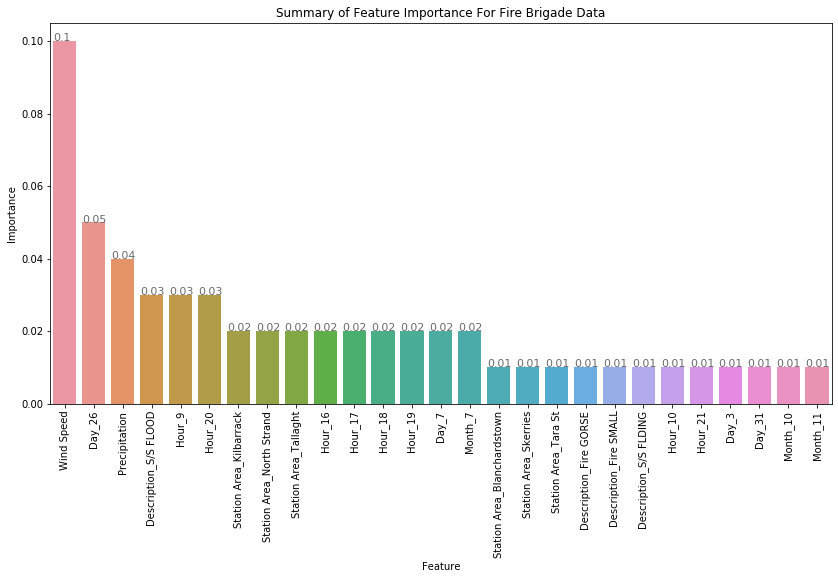

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax =plt.subplots()
fig.set_size_inches(14,7)
ax = sns.barplot(x="Feature", y="Importance", data= fire_importances_graph)
ax.set(ylabel="Importance",xlabel="Feature", title="Summary of Feature Importance For Fire Brigade Data")
#for putting the figures above the bars
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), \
            str(round((i.get_height()), 5)), fontsize=11, color='dimgrey',
                rotation=0)
plt.xticks(rotation=90)
plt.show()

## Arima model

In [97]:
DF_Arima=DF.copy()
DF_Arima.index = DF.Date 
DF_Arima = DF_Arima.resample('D').mean()#switching it to a daily average
train_Arima=train.copy()
test_Arima=test.copy()
train_Arima.index = train.Date
train_Arima = train_Arima.resample('D').mean() 
test_Arima.index = test.Date
test_Arima = test_Arima.resample('D').mean()

In [98]:
DF_Arima.head()

,Response Time,Precipitation,Wind Speed,IsWeekend,Station Area_Blanchardstown,Station Area_Dolphins Barn,Station Area_Donnybrook,Station Area_Dun Laoghaire,Station Area_Dunshaughlin,Station Area_Finglas,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,518.290323,0.0,13.0,0.0,0.032258,0.096774,0.032258,0.032258,0.0,0.064516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,590.705882,0.1,15.1,0.0,0.058824,0.058824,0.058824,0.000000,0.0,0.176471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,447.750000,0.0,12.3,0.0,0.041667,0.125000,0.125000,0.083333,0.0,0.125000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,635.806452,0.0,16.4,0.0,0.032258,0.161290,0.032258,0.129032,0.0,0.032258,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,545.685714,0.0,16.1,1.0,0.028571,0.085714,0.114286,0.200000,0.0,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


PLotting the acf and pacf graphs in order to give a starting point on the ARIMA model ordering

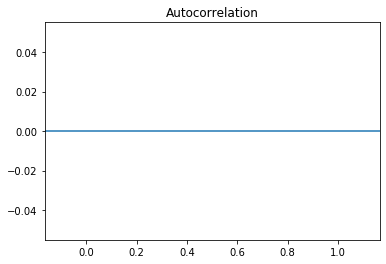

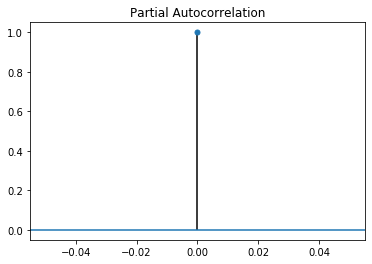

In [99]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
arima_series=train_Arima['Response Time']
arima_series= pd.Series(arima_series)
plot_acf(arima_series)
plot_pacf(arima_series)
pyplot.show()

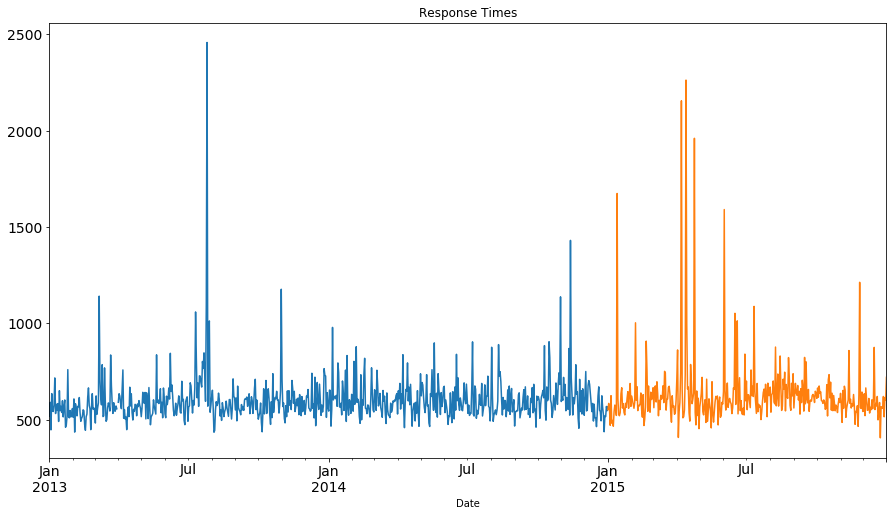

In [100]:
import matplotlib.pyplot as plt 
train_Arima['Response Time'].plot(figsize=(15,8), title= 'Response Times', fontsize=14)
test_Arima['Response Time'].plot(figsize=(15,8), title= 'Response Times', fontsize=14)
plt.show()

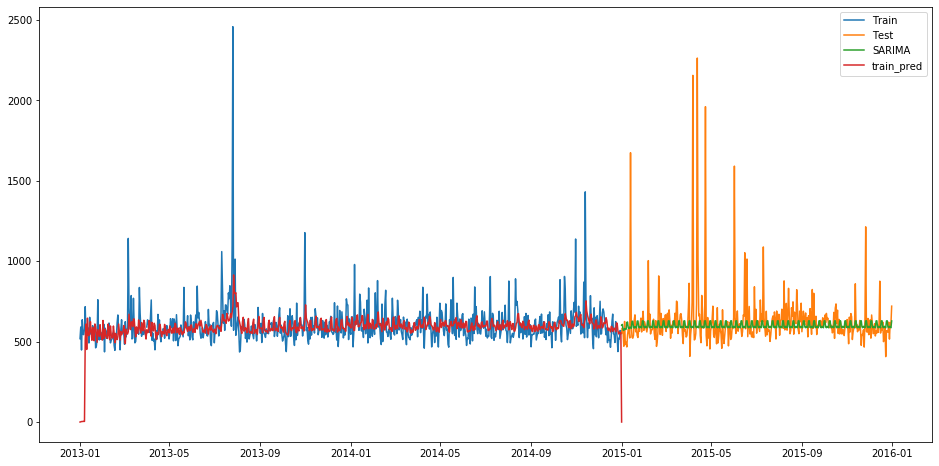

In [101]:
arima_pred_test = test_Arima.copy()
arima_pred_train= train_Arima.copy()
#tested several different versions of the orderings 
fit1 = sm.tsa.statespace.SARIMAX(train_Arima['Response Time'], order=(1, 0, 1),seasonal_order=(0,1,1,7)).fit()
arima_pred_train['SARIMA'] = fit1.predict(start="2013-01-01", end="2014-12-31")
arima_pred_test['SARIMA'] = fit1.predict(start="2015-01-01", end="2015-12-31", dynamic=True)
arima_pred_test=arima_pred_test.fillna(0)
arima_pred_train=arima_pred_train.fillna(0)
plt.figure(figsize=(16,8))
plt.plot( train_Arima['Response Time'], label='Train')
plt.plot(test_Arima['Response Time'], label='Test')
plt.plot(arima_pred_test['SARIMA'], label='SARIMA')
plt.plot(arima_pred_train['SARIMA'], label='train_pred')
plt.legend(loc='best')
plt.show()

Adding results into the dataframe

In [102]:
arima_pred_test.head()
arima_Result_train=arima_pred_train[['SARIMA']]
arima_Result= arima_pred_test[['SARIMA']]
arima_Result_train.reset_index(level=0, inplace=True)
arima_Result.reset_index(level=0, inplace=True)
arima_Result.head()

,Date,SARIMA
0,2015-01-01,601.728246
1,2015-01-02,606.726933
2,2015-01-03,572.117171
3,2015-01-04,569.585554
4,2015-01-05,580.778718


In [103]:
arima_Result_train.head()

,Date,SARIMA
0,2013-01-01,0.000000
1,2013-01-02,1.551791
2,2013-01-03,2.902082
3,2013-01-04,3.383513
4,2013-01-05,4.124738


Merging the data back into the main dataframe, so that each record correpsonding to the day in the arima results will be filled with ARIMA predicted response time, this is similar to the weather data merging that was done above.

In [104]:
test=pd.merge(test,arima_Result, on='Date')
train=pd.merge(train,arima_Result_train, on='Date')
test.head()

,Date,TOC,IA,Response Time,Precipitation,Wind Speed,IsWeekend,Station Area_Blanchardstown,Station Area_Dolphins Barn,Station Area_Donnybrook,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,2015 Base Prediction,Predictions,RF Predictions,SARIMA
0,2015-01-01,2015-01-01 00:00:05,2015-01-01 00:06:00,355.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,628.131045,576.461224,511.428333,601.728246
1,2015-01-01,2015-01-01 00:00:17,2015-01-01 00:13:22,785.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,628.131045,775.007336,793.575000,601.728246
2,2015-01-01,2015-01-01 00:01:25,2015-01-01 00:08:16,411.0,0.2,27.6,0.0,1,0,0,...,0,0,0,0,0,0,628.131045,595.297074,730.040000,601.728246
3,2015-01-01,2015-01-01 00:00:56,2015-01-01 00:05:46,290.0,0.2,27.6,0.0,0,1,0,...,0,0,0,0,0,0,628.131045,405.714771,403.211806,601.728246
4,2015-01-01,2015-01-01 00:01:06,2015-01-01 00:12:23,677.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,628.131045,625.453800,727.689444,601.728246


In [105]:
test.head()

,Date,TOC,IA,Response Time,Precipitation,Wind Speed,IsWeekend,Station Area_Blanchardstown,Station Area_Dolphins Barn,Station Area_Donnybrook,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,2015 Base Prediction,Predictions,RF Predictions,SARIMA
0,2015-01-01,2015-01-01 00:00:05,2015-01-01 00:06:00,355.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,628.131045,576.461224,511.428333,601.728246
1,2015-01-01,2015-01-01 00:00:17,2015-01-01 00:13:22,785.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,628.131045,775.007336,793.575000,601.728246
2,2015-01-01,2015-01-01 00:01:25,2015-01-01 00:08:16,411.0,0.2,27.6,0.0,1,0,0,...,0,0,0,0,0,0,628.131045,595.297074,730.040000,601.728246
3,2015-01-01,2015-01-01 00:00:56,2015-01-01 00:05:46,290.0,0.2,27.6,0.0,0,1,0,...,0,0,0,0,0,0,628.131045,405.714771,403.211806,601.728246
4,2015-01-01,2015-01-01 00:01:06,2015-01-01 00:12:23,677.0,0.2,27.6,0.0,0,0,0,...,0,0,0,0,0,0,628.131045,625.453800,727.689444,601.728246


In [106]:
train.head()

,Date,TOC,IA,Response Time,Precipitation,Wind Speed,IsWeekend,Station Area_Blanchardstown,Station Area_Dolphins Barn,Station Area_Donnybrook,...,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Predictions,Predictions_improved,RF Predictions,SARIMA
0,2013-01-01,2013-01-01 01:27:19,2013-01-01 01:58:54,1895.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,687.669610,734.950916,1454.026032,0.0
1,2013-01-01,2013-01-01 01:49:57,2013-01-01 01:55:43,346.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,612.232078,660.849124,400.478333,0.0
2,2013-01-01,2013-01-01 03:35:24,2013-01-01 03:41:20,356.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,392.683311,406.348764,376.600000,0.0
3,2013-01-01,2013-01-01 04:12:51,2013-01-01 04:20:48,477.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,635.370182,660.849124,482.716667,0.0
4,2013-01-01,2013-01-01 04:14:24,2013-01-01 04:20:47,383.0,0.0,13.0,0.0,0,0,0,...,0,0,0,0,0,0,372.174003,395.698409,416.116667,0.0


calculating evaluation metrics for arima predictions on its own

In [107]:
arima_rmse=(np.sqrt(metrics.mean_squared_error(test['Response Time'],test['SARIMA'])))
print(arima_rmse)

812.9846401673819


In [108]:
arima_mae=(metrics.mean_absolute_error(test['Response Time'],test['SARIMA']))
print(arima_mae)

240.81589132038096


In [109]:
arima_accuracy=100-(mean_absolute_percentage_error(test['Response Time'],test['SARIMA']))
print(arima_accuracy)

52.091597254375145


In [110]:
arima=(metrics.r2_score(test['Response Time'],test['SARIMA']))
print(arima)

-0.0012537797855722843


## Linear Arima Model

In [111]:
from sklearn.linear_model import LinearRegression
lr= LinearRegression()
Y_train=train['Response Time']
X_train=train.drop(columns=['Response Time','Date','TOC','IA','Predictions','Predictions_improved','RF Predictions'])
Y_test=test['Response Time']
X_test=test.drop(columns=['Response Time','Date','TOC','IA','2015 Base Prediction','Predictions','RF Predictions'])

In [112]:
X_train.head()

,Precipitation,Wind Speed,IsWeekend,Station Area_Blanchardstown,Station Area_Dolphins Barn,Station Area_Donnybrook,Station Area_Dun Laoghaire,Station Area_Dunshaughlin,Station Area_Finglas,Station Area_Kilbarrack,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,SARIMA
0,0.0,13.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0.0,13.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0.0,13.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0.0,13.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0.0,13.0,0.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0


In [113]:
lr.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [114]:
import statsmodels.api as sm

model = sm.OLS(Y_train, X_train).fit()
y_pred = model.predict(X_train)
y_pred_2015=model.predict(X_test)
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:          Response Time   R-squared (uncentered):                   0.675
Model:                            OLS   Adj. R-squared (uncentered):              0.673
Method:                 Least Squares   F-statistic:                              294.7
Date:                Fri, 08 May 2020   Prob (F-statistic):                        0.00
Time:                        16:31:41   Log-Likelihood:                     -1.5894e+05
No. Observations:               21160   AIC:                                  3.182e+05
Df Residuals:                   21012   BIC:                                  3.194e+05
Df Model:                         148                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [115]:
train['LA_Predictions']=y_pred

In [116]:
print(np.sqrt(metrics.mean_squared_error(Y_train,y_pred)))

442.53278646728535


In [117]:
print(metrics.mean_absolute_error(Y_train,y_pred))

217.49424341797243


In [118]:
mean_absolute_percentage_error(Y_train,y_pred)

46.93549298240477

In [119]:
LA_rmse=(np.sqrt(metrics.mean_squared_error(Y_test,y_pred_2015)))
print(LA_rmse)

793.2576595951346


In [120]:
LA_mae=(metrics.mean_absolute_error(Y_test,y_pred_2015))
print(LA_mae)

221.63329438216746


In [121]:
LA_accuracy=100-mean_absolute_percentage_error(Y_test,y_pred_2015)
print(LA_accuracy)

56.413859945082905


## Plotting graphs of results

In [122]:
rmse_results = [('2015 baseline',base_2015_rmse),
                ('Linear Regression',linear_rmse),
                ('Reduced Linear Model',reduced_linear_rmse),
                ('Random Forest',RFR_rmse),
                ('Linear_Arima',LA_rmse)]

In [123]:
final_rmse = pd.DataFrame(rmse_results, columns = ['Method','RMSE'])


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

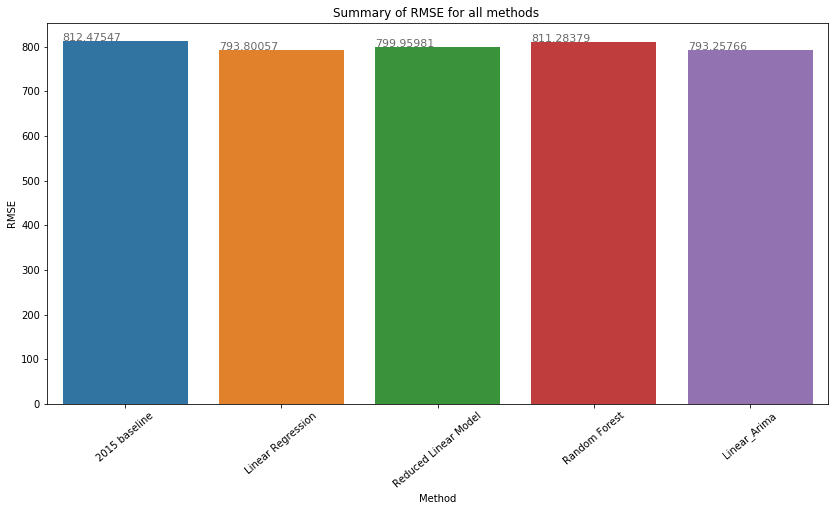

In [124]:
import seaborn as sns
fig, ax =plt.subplots()
fig.set_size_inches(14,7)
ax = sns.barplot(x="Method", y="RMSE", data= final_rmse)
ax.set(ylabel="RMSE",xlabel="Method", title="Summary of RMSE for all methods ")
#for putting the figures above the bars
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), \
            str(round((i.get_height()), 5)), fontsize=11, color='dimgrey',
                rotation=0)
plt.xticks(rotation=40)

In [125]:
mae_results = [('2015 baseline',base_2015_mae),
                ('Linear Regression',linear_mae),
                ('Reduced Linear Model',reduced_linear_mae),
                ('Random Forest',RFR_mae),
                ('Linear_Arima',LA_mae)]

In [126]:
final_mae = pd.DataFrame(mae_results, columns = ['Method','MAE'])

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

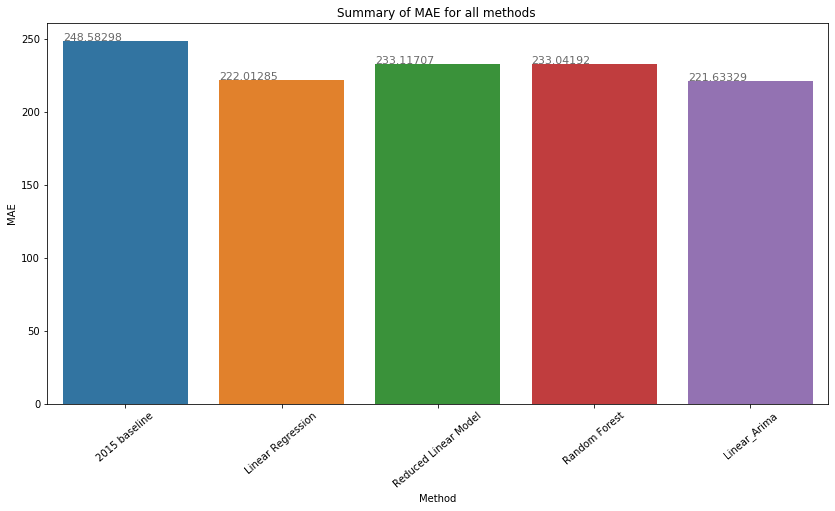

In [127]:
import seaborn as sns
fig, ax =plt.subplots()
fig.set_size_inches(14,7)
ax = sns.barplot(x="Method", y="MAE", data= final_mae)
ax.set(ylabel="MAE",xlabel="Method", title="Summary of MAE for all methods ")
#for putting the figures above the bars
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), \
            str(round((i.get_height()), 5)), fontsize=11, color='dimgrey',
                rotation=0)
plt.xticks(rotation=40)

In [128]:
base_2015_var=base_2015_rmse-base_2015_mae
linear_var=linear_rmse-linear_mae
reduced_linear_var=reduced_linear_rmse-reduced_linear_mae
RFR_var=RFR_rmse-RFR_mae
LA_var=LA_rmse-LA_mae

In [129]:
var_results = [('2015 baseline',base_2015_var),
                ('Linear Regression',linear_var),
                ('Reduced Linear Model',reduced_linear_var),
                ('Random Forest',RFR_var),
                ('Linear_Arima',LA_var)]

In [130]:
final_var = pd.DataFrame(var_results, columns = ['Method','variance'])

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

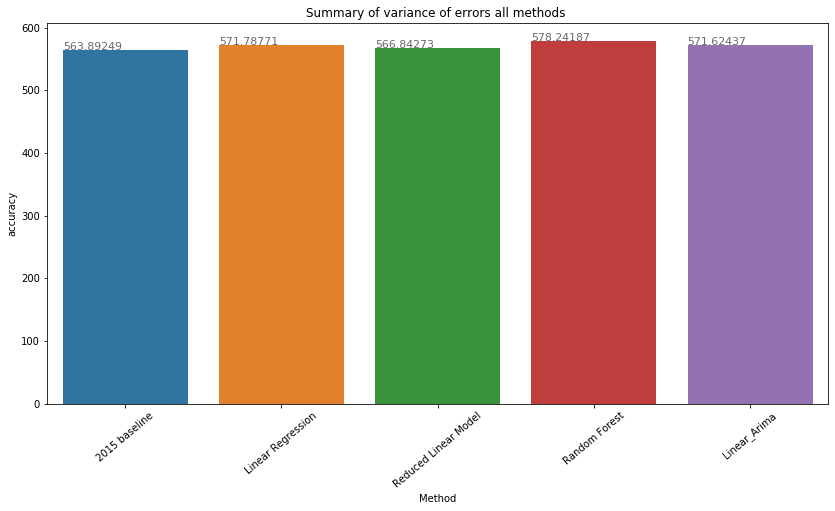

In [131]:
fig, ax =plt.subplots()
fig.set_size_inches(14,7)
ax = sns.barplot(x="Method", y="variance", data= final_var)
ax.set(ylabel="accuracy",xlabel="Method", title="Summary of variance of errors all methods ")
#for putting the figures above the bars
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), \
            str(round((i.get_height()), 5)), fontsize=11, color='dimgrey',
                rotation=0)
plt.xticks(rotation=40)

In [132]:
accuracy_results = [('2015 baseline',base_2015_accuracy),
                ('Linear Regression',linear_accuracy),
                ('Reduced Linear Model',reduced_linear_accuracy),
                ('Random Forest',RFR_accuracy),
                ('Linear_Arima',LA_accuracy)]

In [133]:
final_accuracy = pd.DataFrame(accuracy_results, columns = ['Method','accuracy'])

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

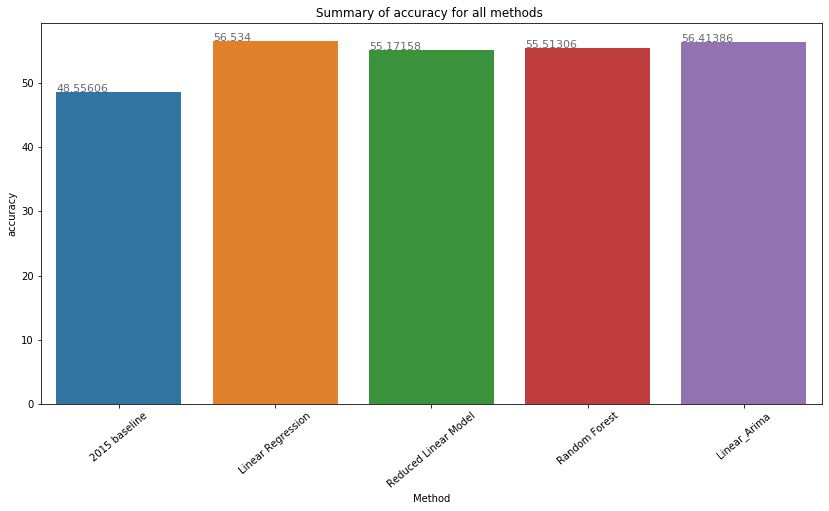

In [134]:
fig, ax =plt.subplots()
fig.set_size_inches(14,7)
ax = sns.barplot(x="Method", y="accuracy", data= final_accuracy)
ax.set(ylabel="accuracy",xlabel="Method", title="Summary of accuracy for all methods ")
#for putting the figures above the bars
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), \
            str(round((i.get_height()), 5)), fontsize=11, color='dimgrey',
                rotation=0)
plt.xticks(rotation=40)